### Importation of Libraries 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

### Data Reading and Wrangling

##### Airlines and Airport Datasets

In [21]:
airlines = pd.read_csv('data/airlines.csv')
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [22]:
airports = pd.read_csv('data/airports.csv')
airports.columns = airports.columns.str.lower()
airports # This dataset will be merged with the flights dataset since it contains information 
         # that is of importance to our analysis and ultimate regression model that will be based 
         # off of the flights dataset. 

,iata_code,airport,city,state,country,latitude,longitude
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


##### Flights Dataset (and Merging of aforementioned dataset with Airports dataset)

In [37]:
flights = pd.read_csv('data/flights.csv')
flights.columns = flights.columns.str.lower()
flights = flights.merge(right=airports, how='left', left_on='origin_airport', right_on='iata_code')

/var/folders/0r/5f62klsd5972dd_55bcz2qq80000gn/T/ipykernel_15649/3697502590.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('data/flights.csv')


In [38]:
X = flights[flights.columns.difference([
    'year', # all are 2015
    'flight_number', # irrelevant
    'tail_number', # irrelevant
    'departure_time', # collinearity: scheduled_departure + departure_delay
    'wheels_off', # co: departure_time + taxi_out
    'elapsed_time', # co: scheduled_time + departure_delay
    'air_time', # co: elapsed_time - taxi_out - taxi_in
    'wheels_on', # co: arrival_time - taxi_in
    # leave in arrival_time because of time changes
    'arrival_delay', # co: departure_delay
    'diverted', # occurs after delay, can't be used to predict delay time
    'cancelled', # occurs after delay,
    'cancellation_reason',
    'air_system_delay',
    'security_delay',
    'airline_delay',
    'late_aircraft_delay',
    'weather_delay',
    'iata_code', # same as origin_airport
    'airport', # airport already described in origin_airport
    'country' # all are USA
])]

### Data Cleaning and Preparation

In [39]:
X.iloc[:,7:9].astype('category')
flights_sample = X.sample(n=10000)
flights_sample.dtypes

airline                 object
arrival_time           float64
city                    object
day                      int64
day_of_week              int64
departure_delay        float64
destination_airport     object
distance                 int64
latitude               float64
longitude              float64
month                    int64
origin_airport          object
scheduled_arrival        int64
scheduled_departure      int64
scheduled_time         float64
state                   object
taxi_in                float64
taxi_out               float64
dtype: object

In [40]:
flights_sample.columns

Index(['airline', 'arrival_time', 'city', 'day', 'day_of_week',
       'departure_delay', 'destination_airport', 'distance', 'latitude',
       'longitude', 'month', 'origin_airport', 'scheduled_arrival',
       'scheduled_departure', 'scheduled_time', 'state', 'taxi_in',
       'taxi_out'],
      dtype='object')

### Statistical Analysis 

#### Correleation Analysis

In [41]:
# Create correlation matrix
corr_matrix = flights_sample.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.30
highcorr_matrix = upper[(upper > 0.45)]

highcorr_mat = highcorr_matrix.dropna(how='all')
highcorr_mat

,arrival_time,day,day_of_week,departure_delay,distance,latitude,longitude,month,scheduled_arrival,scheduled_departure,scheduled_time,taxi_in,taxi_out
arrival_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86188,0.618597,NaN,NaN,NaN
distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984645,NaN,NaN
scheduled_arrival,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.703198,NaN,NaN,NaN


#### Analysis of Potential Variable Interactions and Transformations 

In [42]:
flights_sample.columns

Index(['airline', 'arrival_time', 'city', 'day', 'day_of_week',
       'departure_delay', 'destination_airport', 'distance', 'latitude',
       'longitude', 'month', 'origin_airport', 'scheduled_arrival',
       'scheduled_departure', 'scheduled_time', 'state', 'taxi_in',
       'taxi_out'],
      dtype='object')

##### Plots of Predictors Against Response Variable

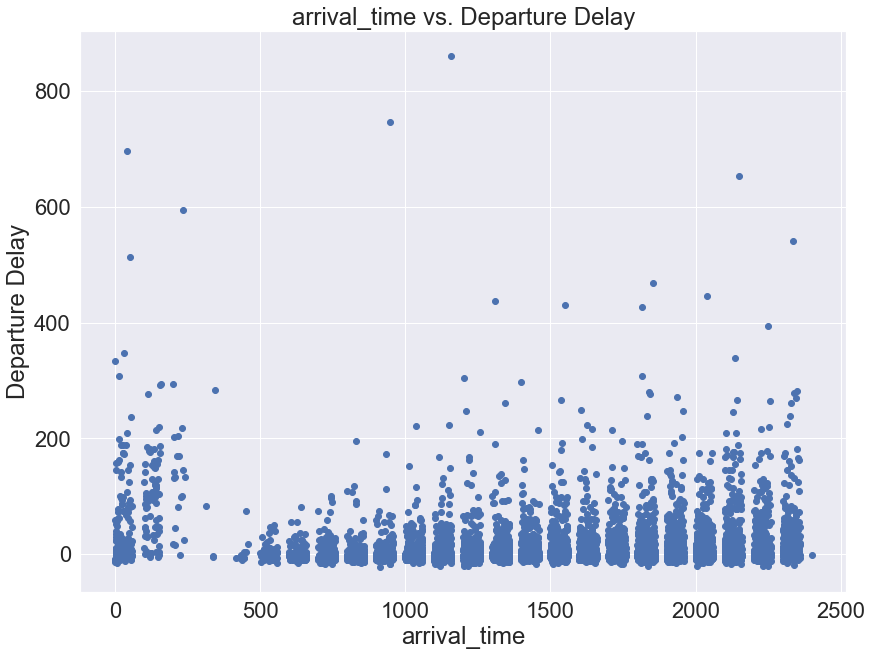

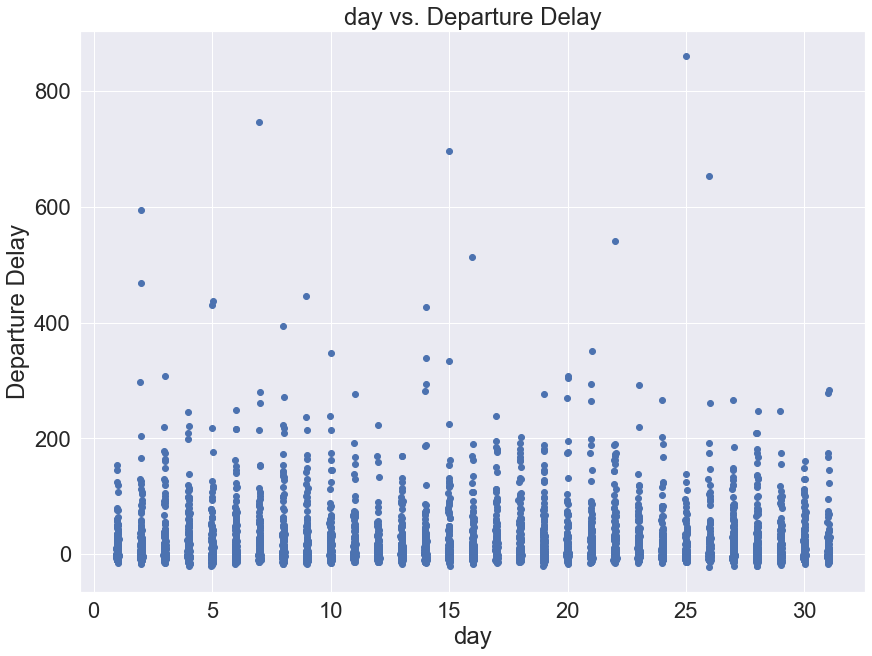

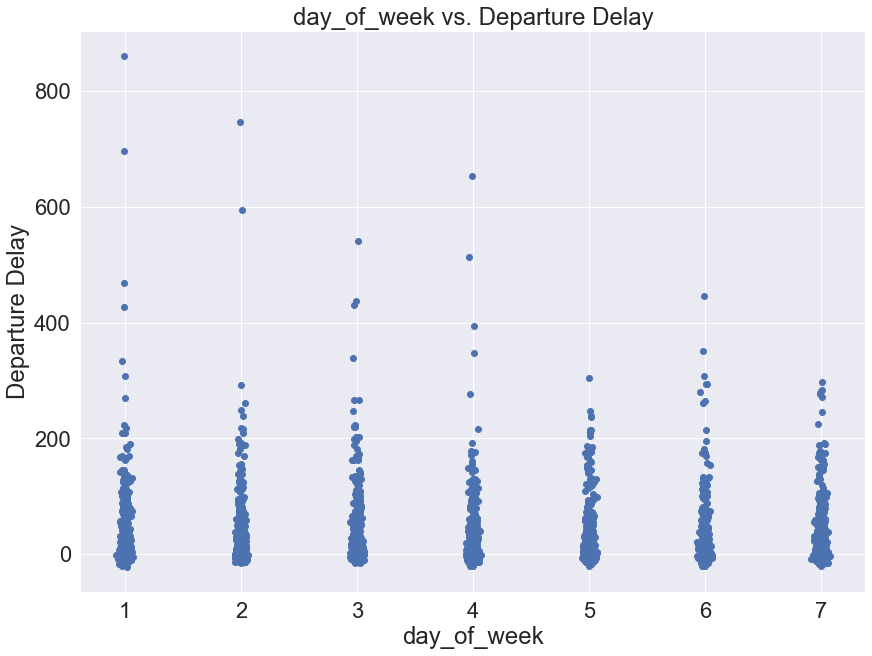

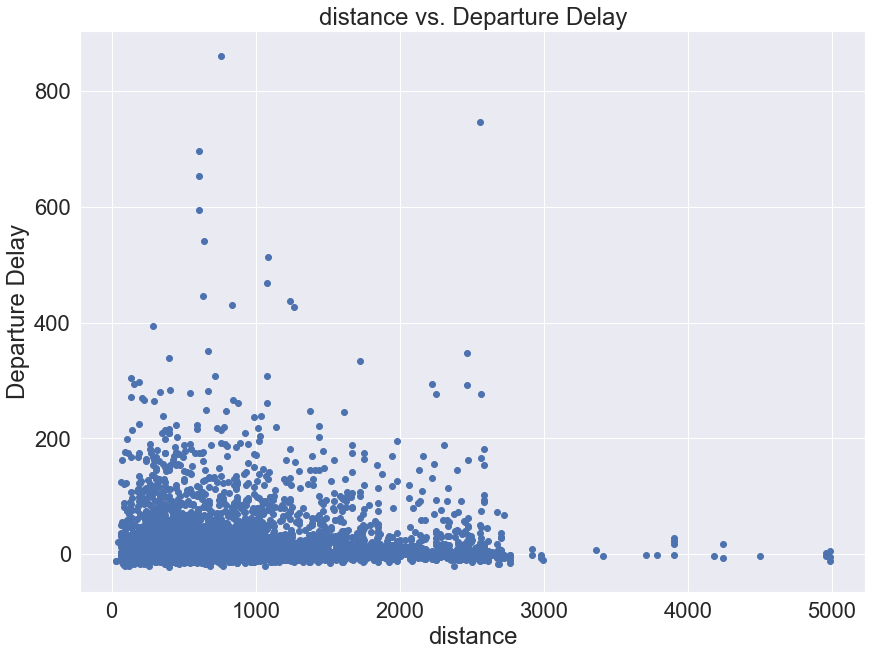

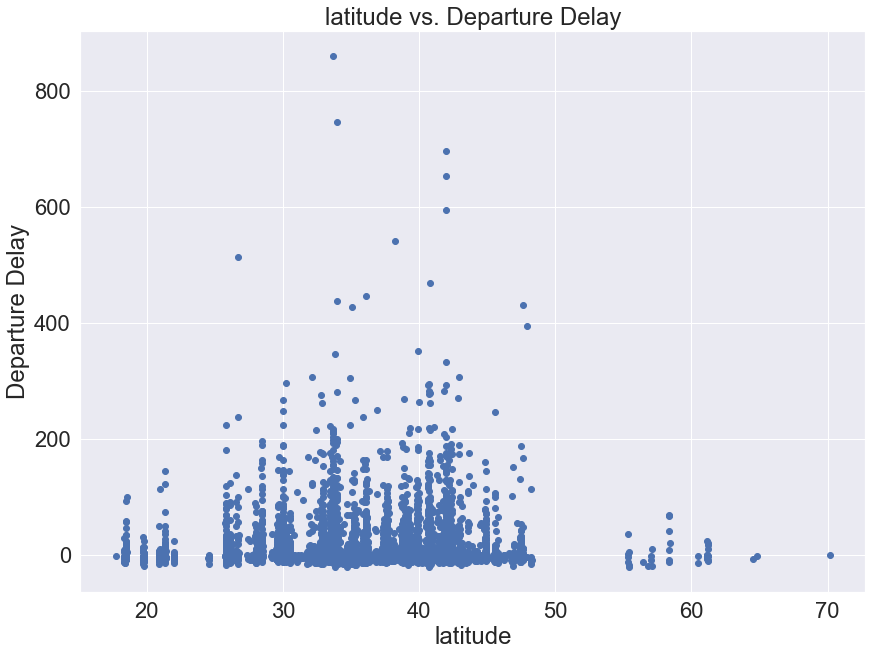

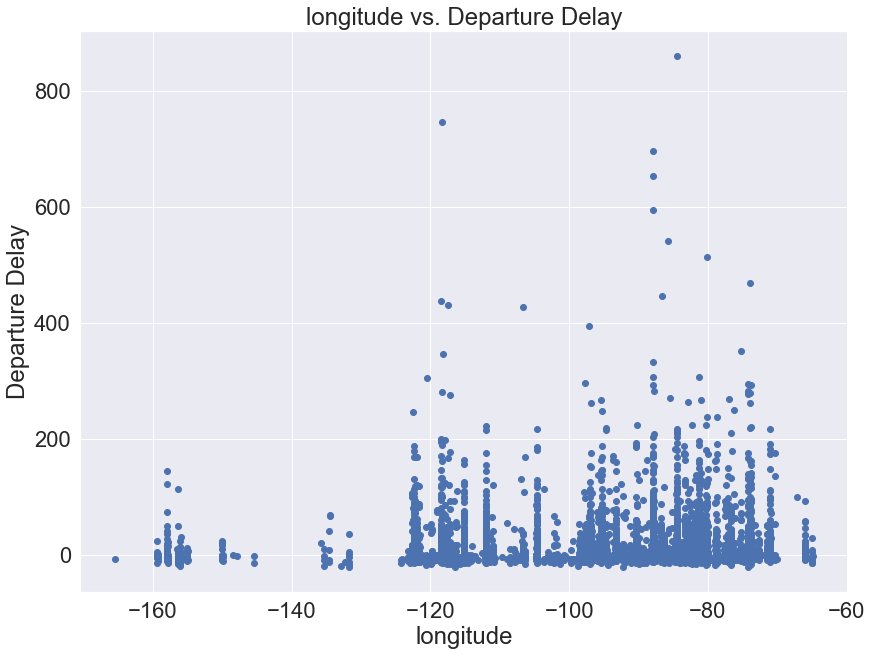

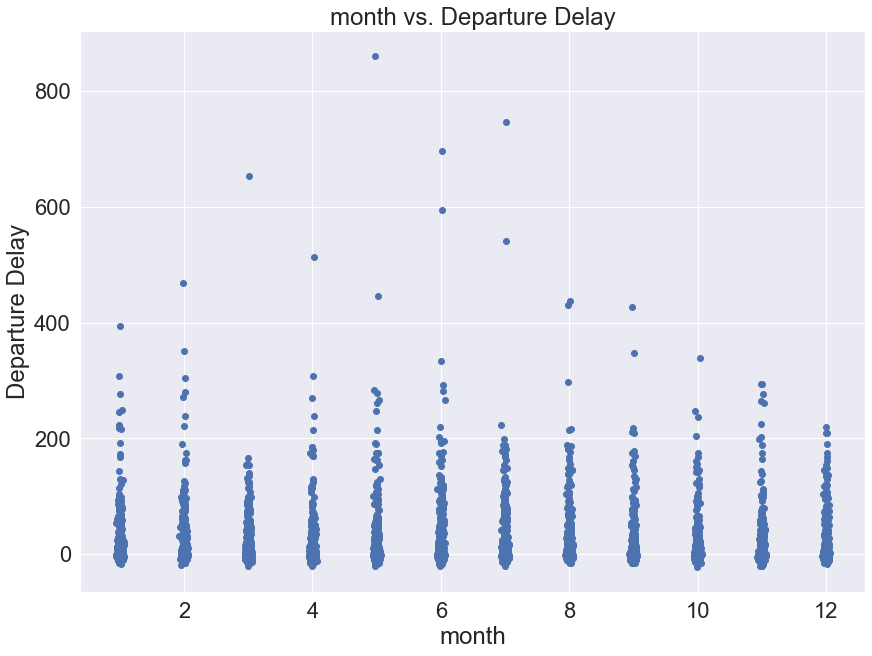

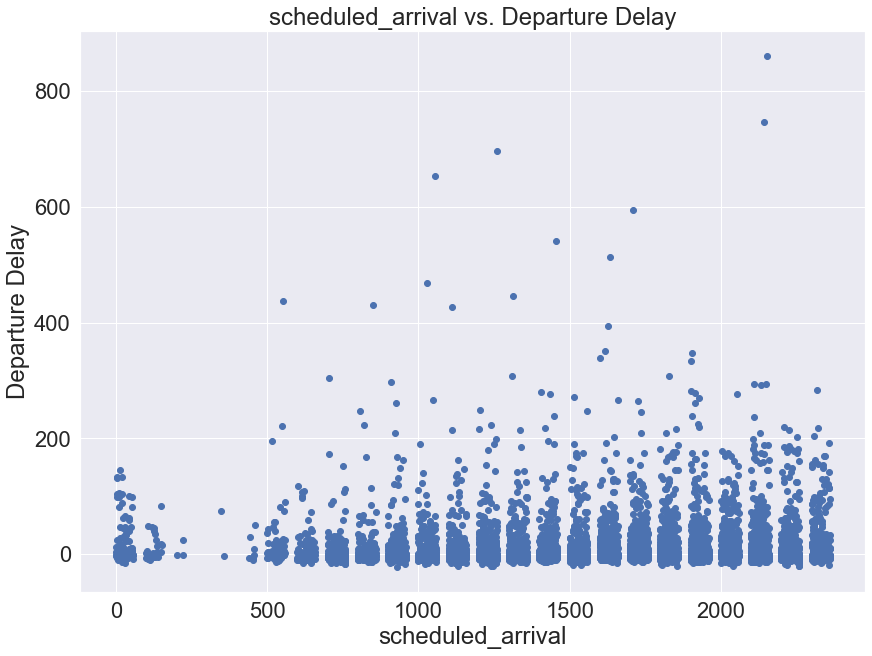

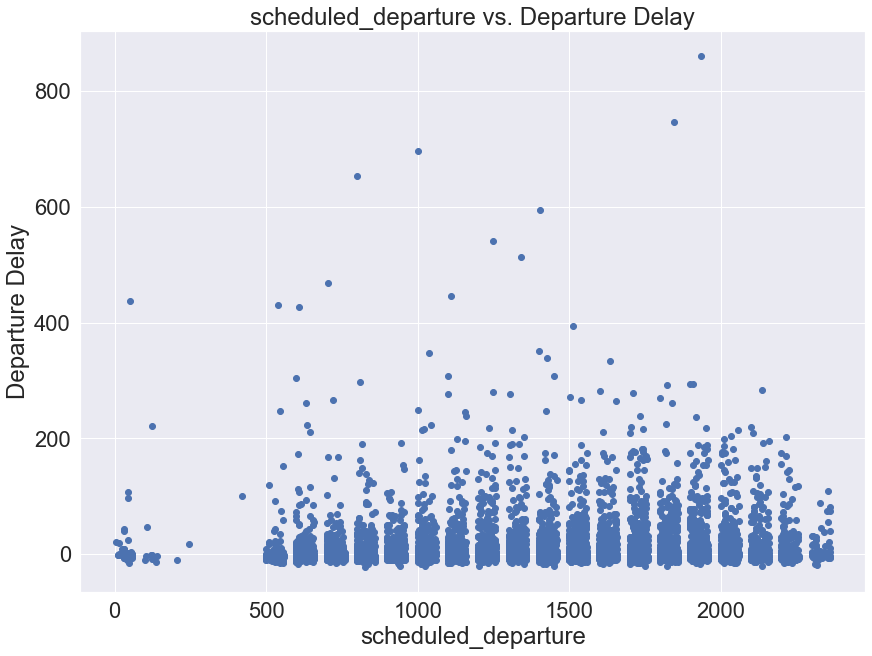

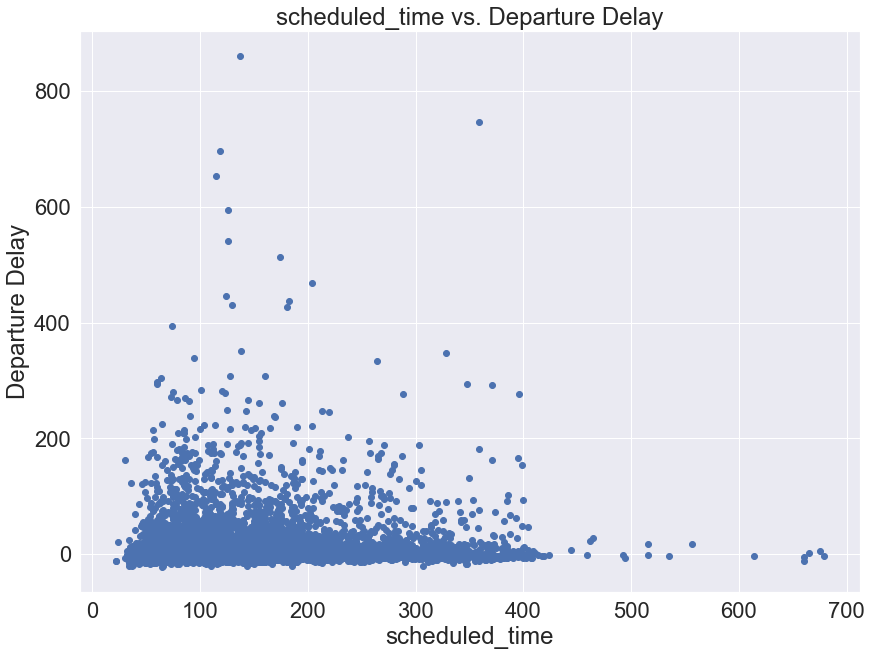

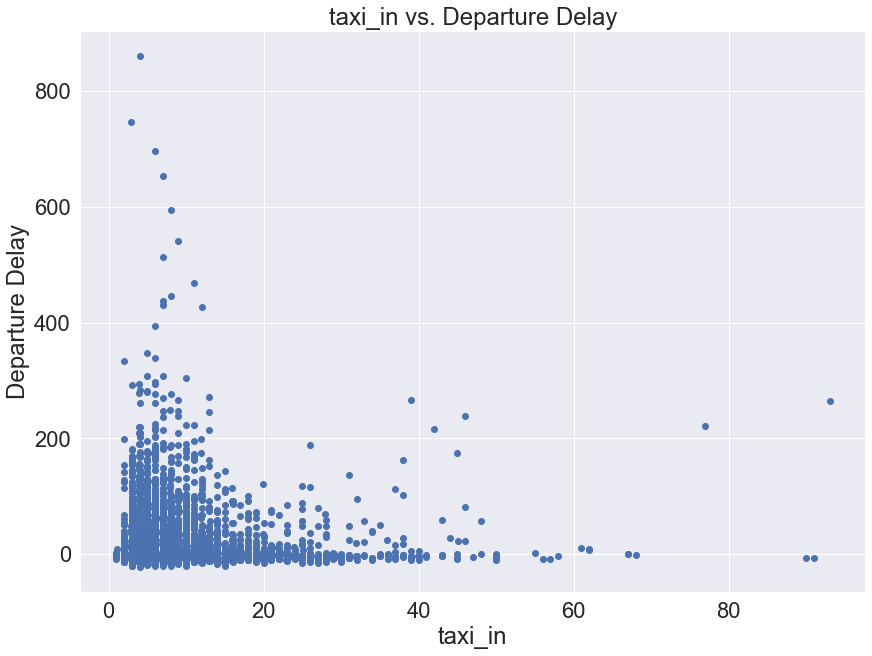

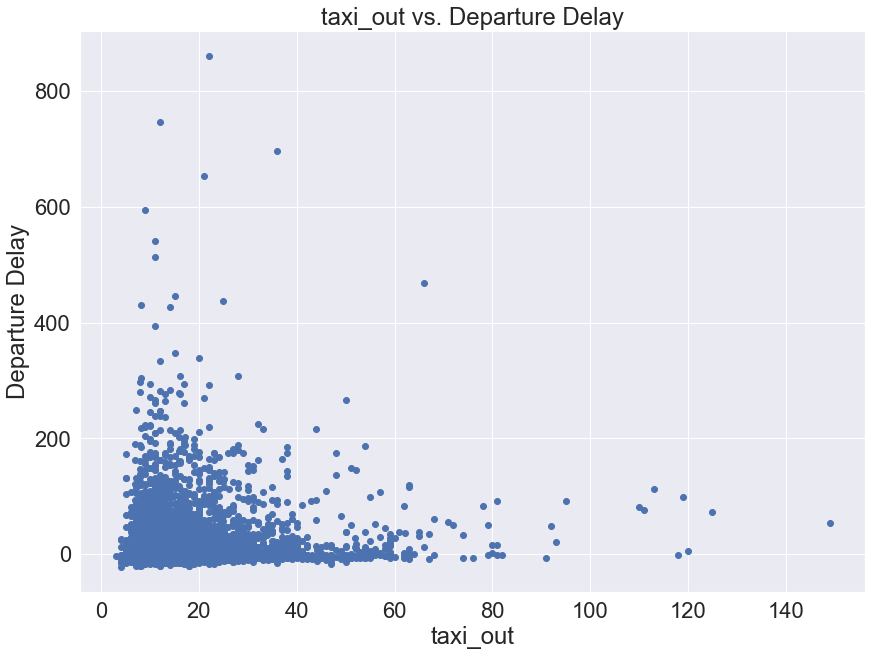

In [63]:
#Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)

for i in flights_sample.columns:
    if (flights_sample[str(i)].dtype == 'int64' or flights_sample[str(i)].dtype == 'float64') and (str(i) != 'departure_delay') :
        plt.figure(figsize=(12,9), layout = 'constrained')
        plt.scatter(jitter(flights_sample[i],0),jitter(flights_sample['departure_delay'],0))
        plt.title(str(i) + ' vs. Departure Delay')
        plt.xlabel(str(i))
        plt.ylabel('Departure Delay')
        # Show/save figure as desired.
        plt.show()

##### Residual Plots of Predictors Against Response Variable

##### Distribution of Predictors

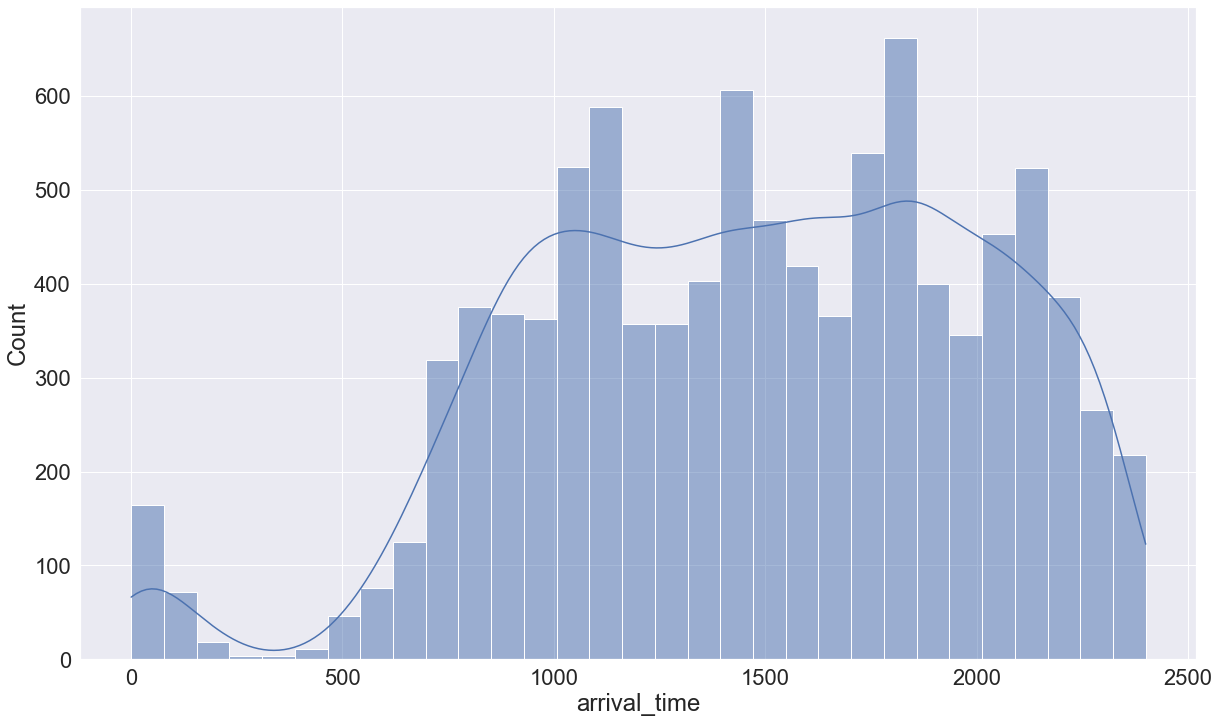

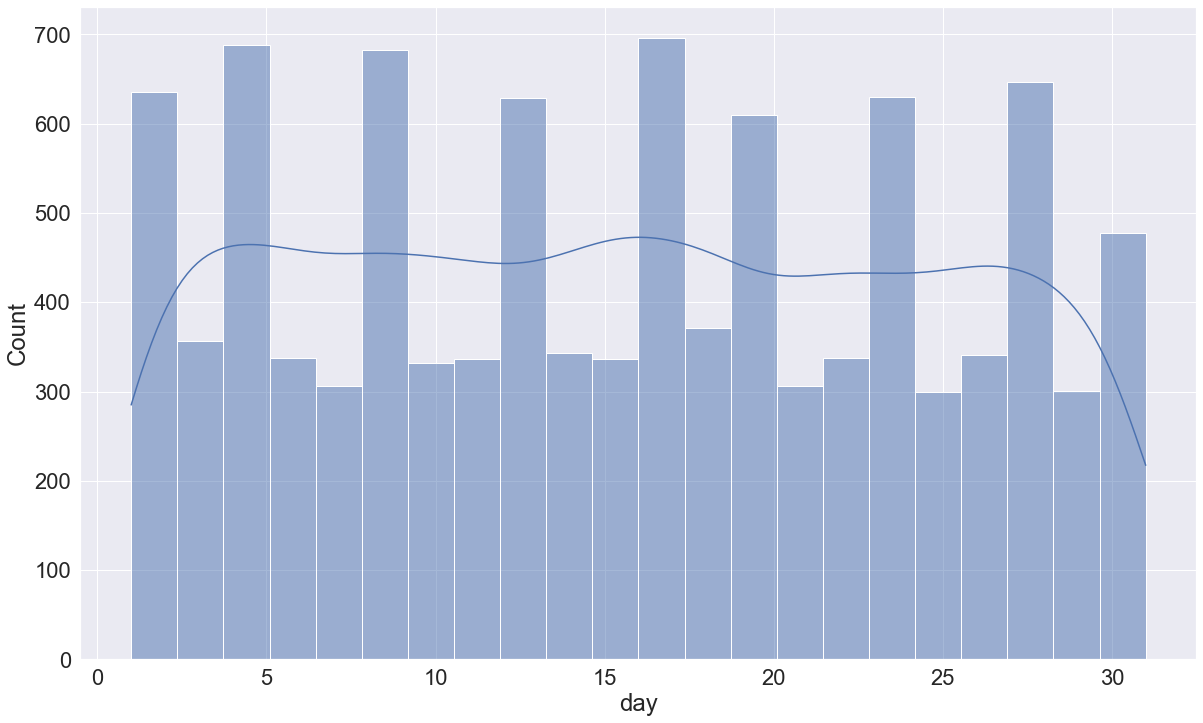

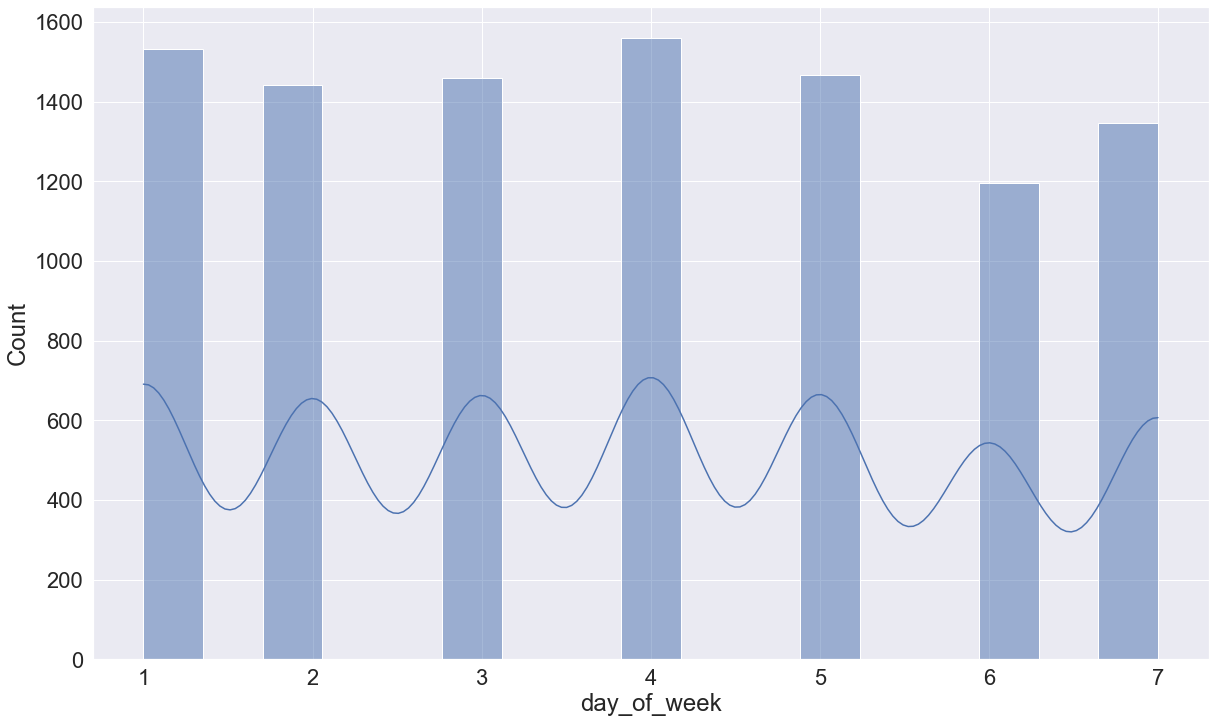

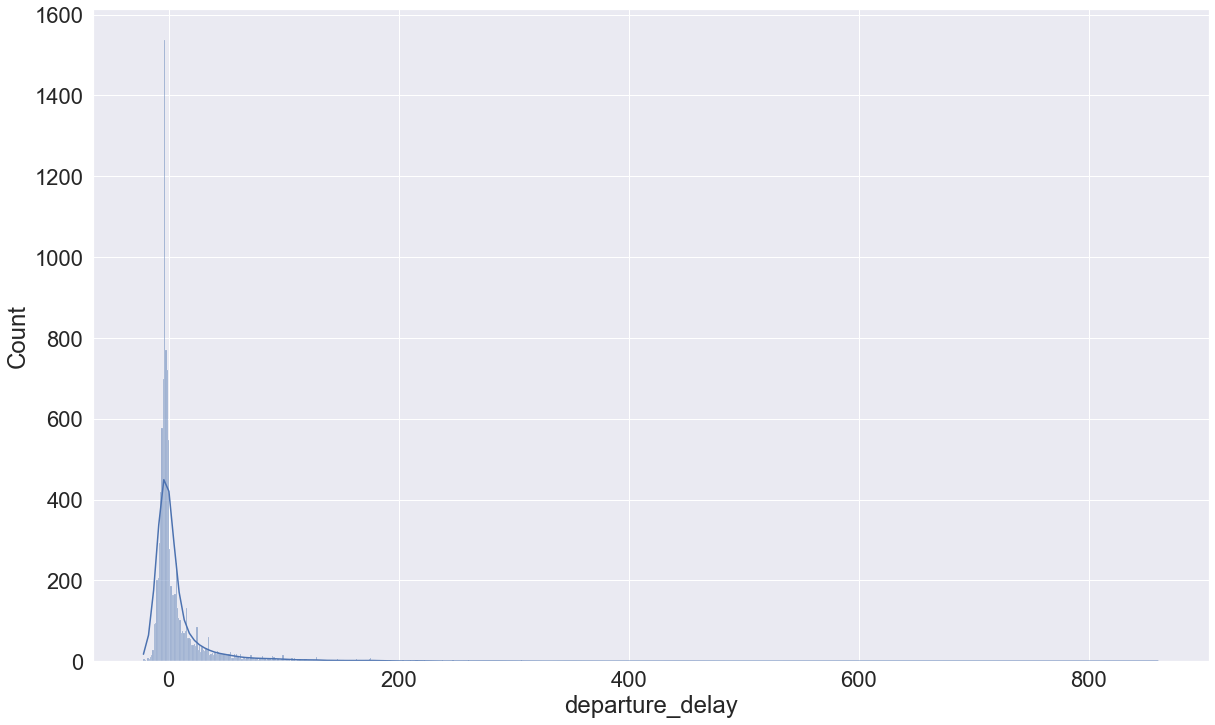

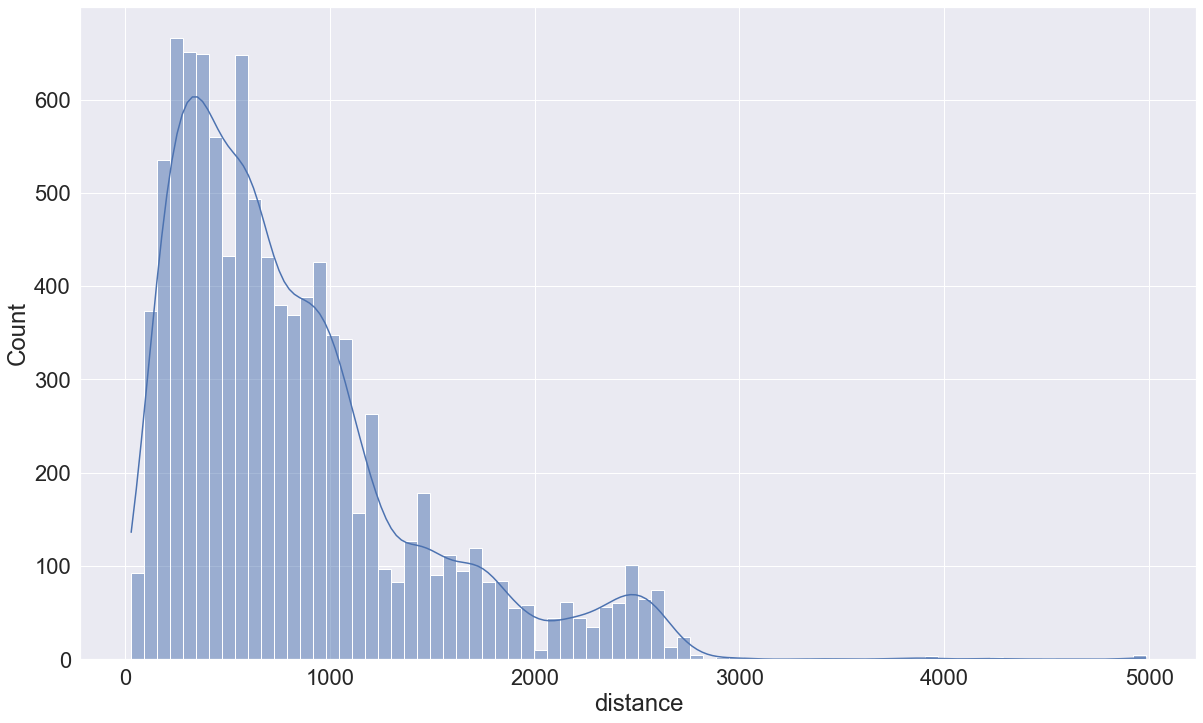

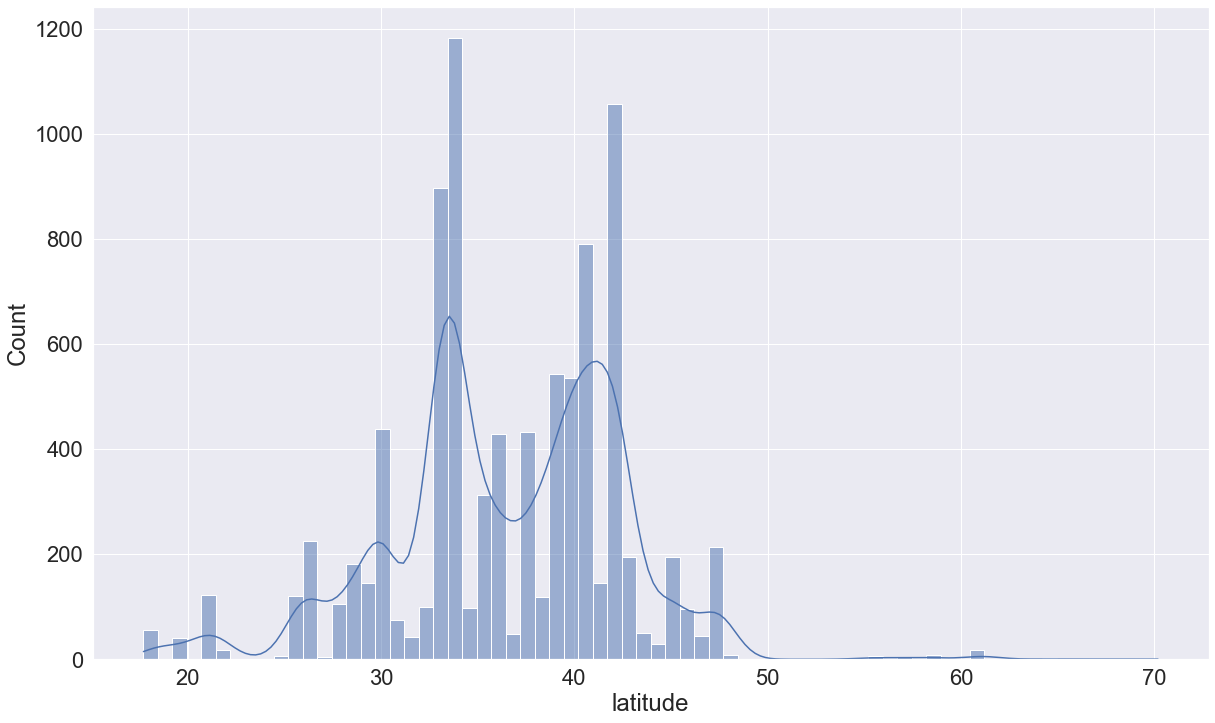

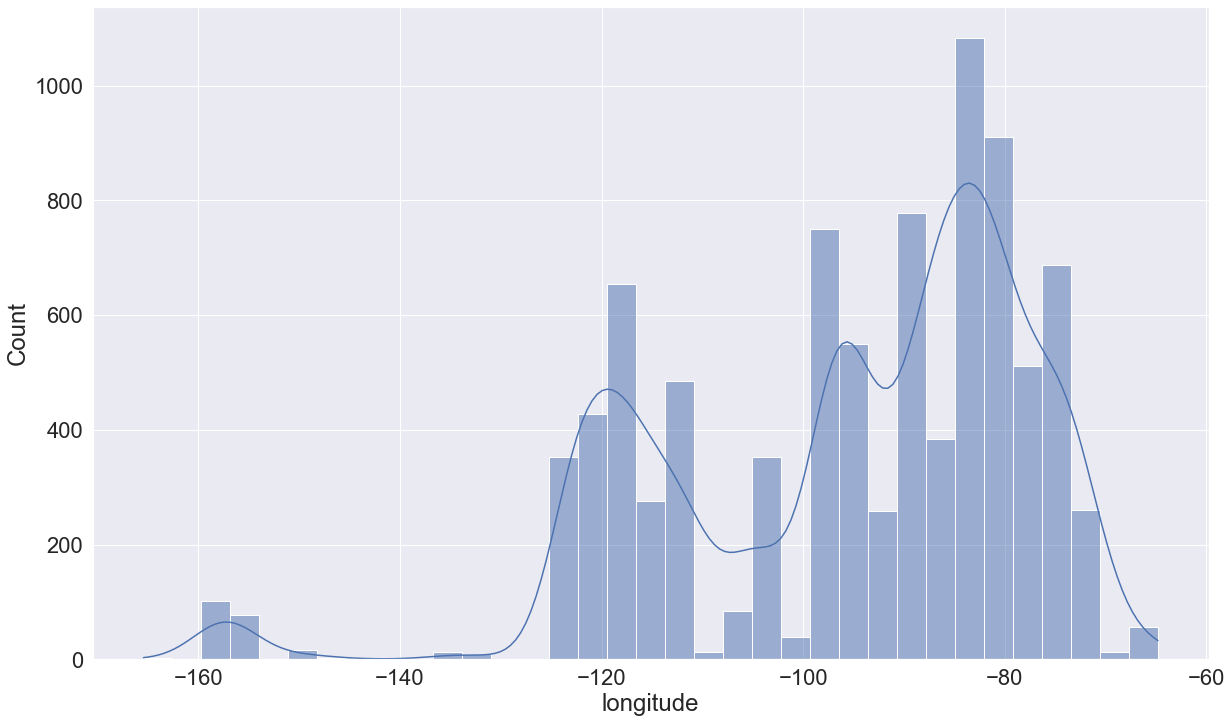

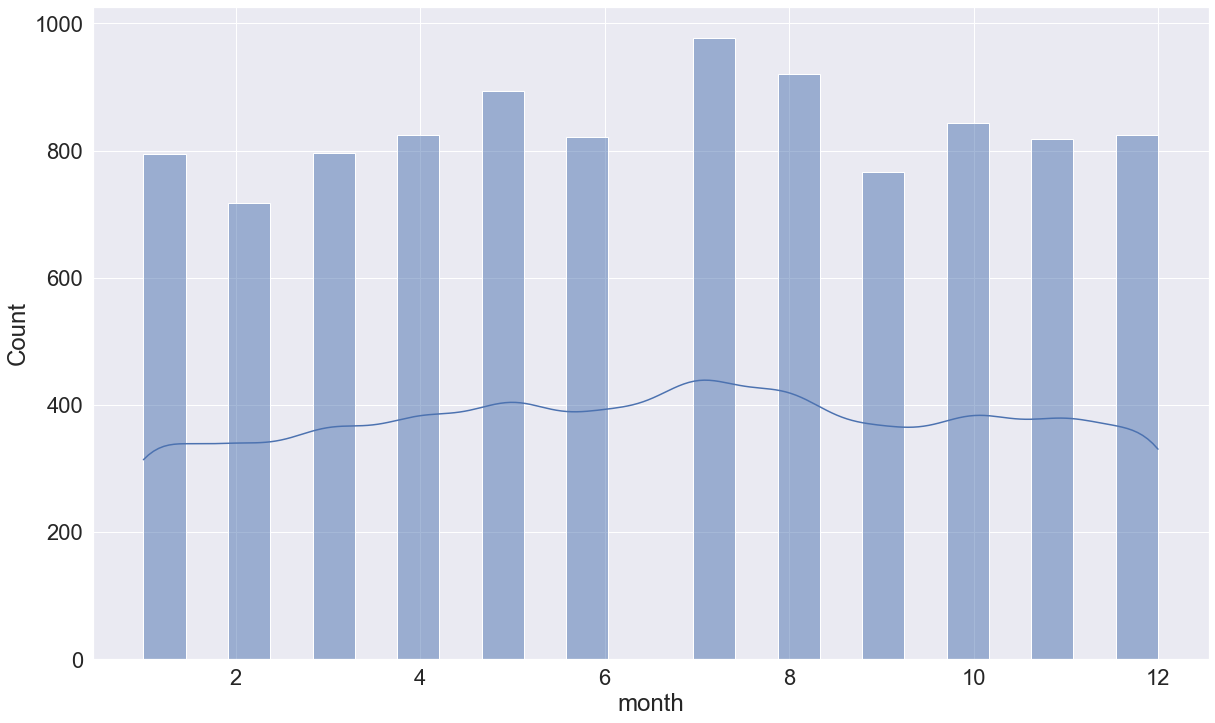

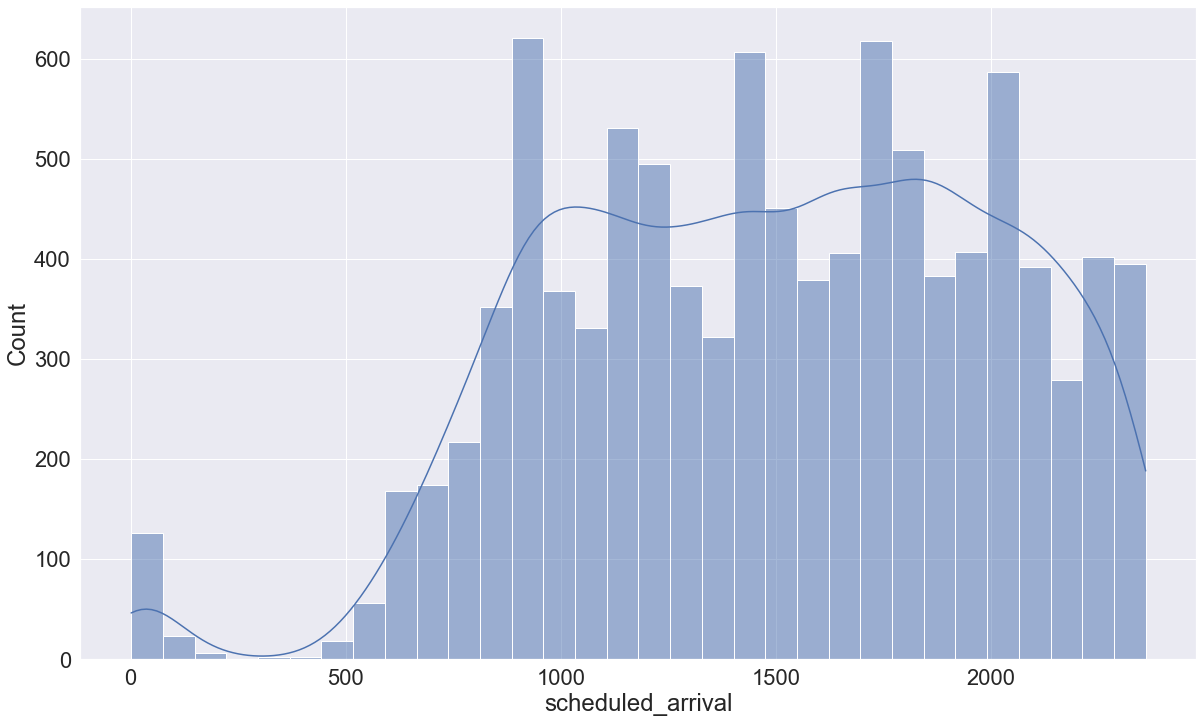

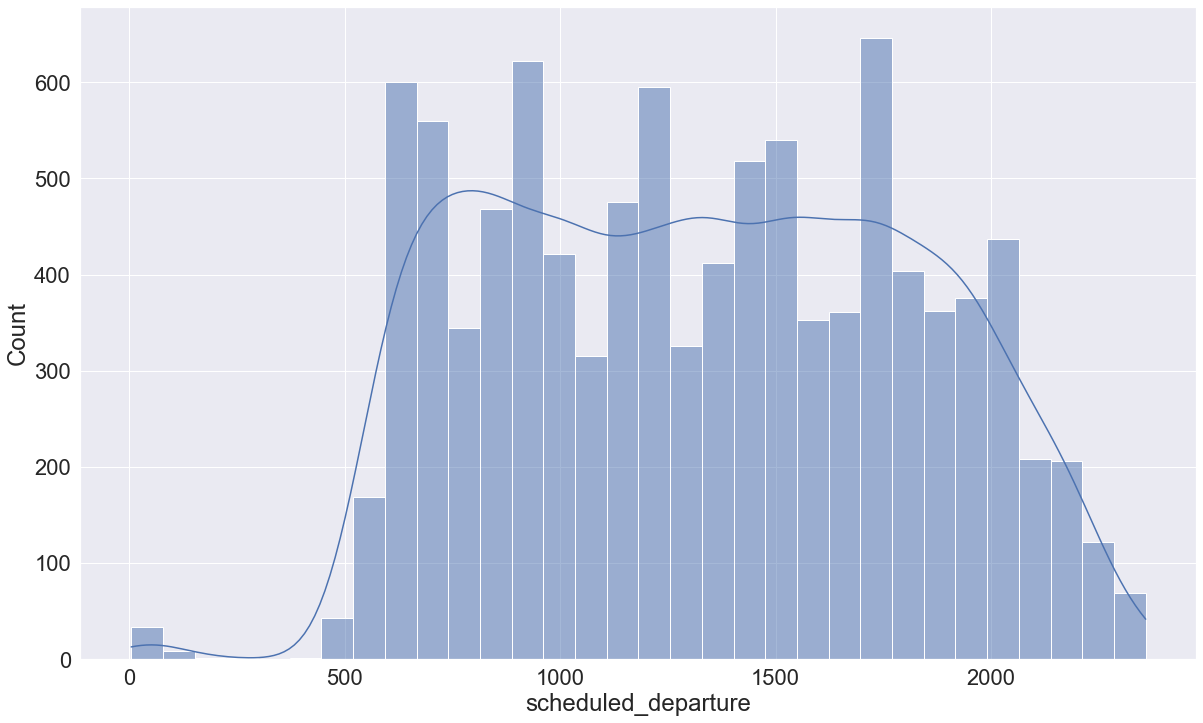

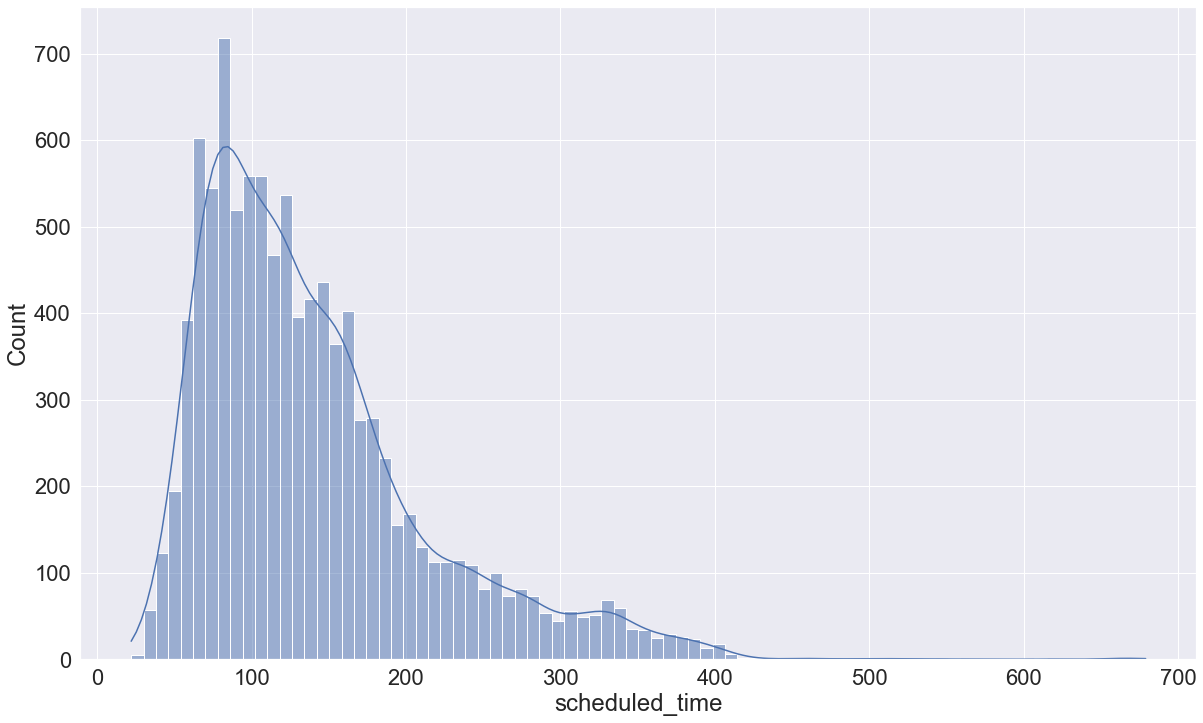

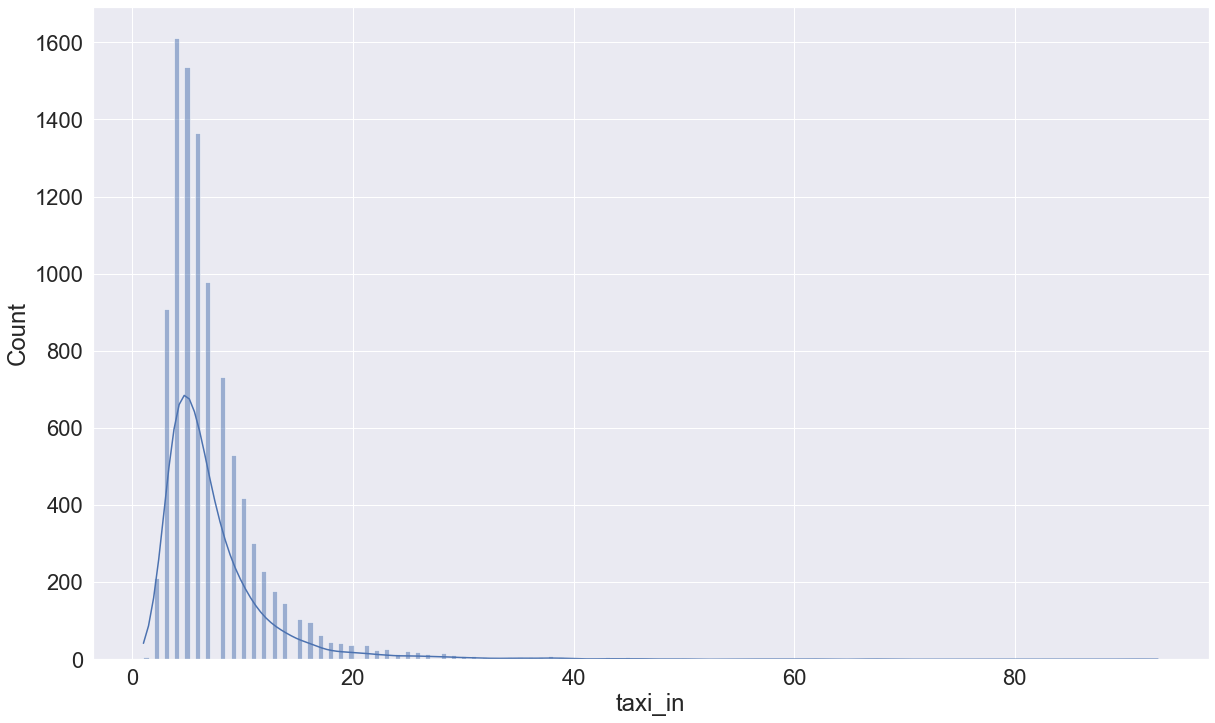

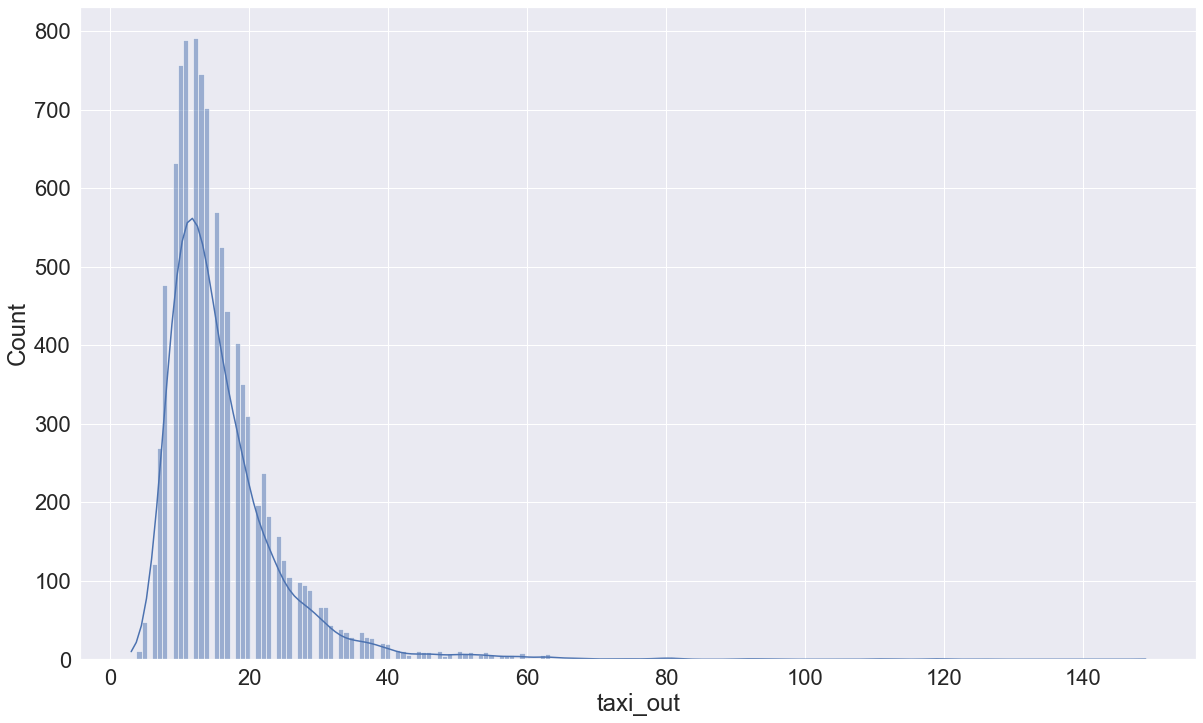

In [55]:
#Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)

for i in flights_sample.columns:
    if (flights_sample[str(i)].dtype == 'int64' or flights_sample[str(i)].dtype == 'float64'):
        sns.set(rc = {'figure.figsize':(20,12)})
        sns.set(font_scale = 2)
        sns.histplot(flights_sample[str(i)],kde=True)
        plt.show()


##### 2D Histogram Binning 

In [53]:
import plotly.graph_objects as go

import numpy as np

x = np.random.randn(500)
y = np.random.randn(500)+1

fig = go.Figure(go.Histogram2d(x=x, y=y, histnorm='probability',
        autobinx=False,
        xbins=dict(start=-3, end=3, size=0.1),
        autobiny=False,
        ybins=dict(start=-2.5, end=4, size=0.1),
        colorscale=[[0, 'rgb(12,51,131)'], [0.25, 'rgb(10,136,186)'], [0.5, 'rgb(242,211,56)'], [0.75, 'rgb(242,143,56)'], [1, 'rgb(217,30,30)']]
    ))
fig.show()

### Linear Regression Model Generation

In [77]:
model = smf.ols(formula='departure_delay ~  taxi_out + longitude + scheduled_time + month + day', data=flights).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4902.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):               0.00
Time:                        23:25:25   Log-Likelihood:            -2.6424e+07
No. Observations:             5241724   AIC:                         5.285e+07
Df Residuals:                 5241718   BIC:                         5.285e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2570      0.109     94.341      0.000      10.044      10.470
taxi_out           0.2225      0.002    120.476      0.000       0.219       0.226
longitude          0.0501      0.001     55.228      0.000       0.048       0.052
scheduled_time     0.0107      0.000     48.904      0.000       0.010       0.011
month             -0.1264      0.005    -26.106      0.000      -0.136      -0.117
day               -0.0021      0.002     -1.153      0.249      -0.006       0.002
==============================================================================
Omnibus:                  7020202.016   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3105011020.333
Skew:                           7.429   Prob(JB):                         0.00
Kurtosis:                     121.305   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [82]:
model = smf.ols(formula= 'departure_delay ~  month*day + I(taxi_out**2) + taxi_in + I(taxi_in**2) + distance + I(distance**2) + longitude + scheduled_departure + ', data=flights_sample).fit()
model.summary()

ValueError: mismatch between column_names and columns coded by given terms